In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

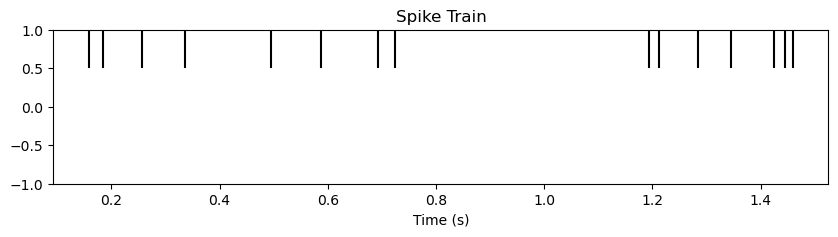

In [37]:
# We generate a poisson process with a firing rate of 15 Hz
# and a duration of 5 seconds
def generate_poisson_process(rate, duration):
    # Generate the time intervals between spikes
    intervals = np.random.exponential(1/rate, int(rate * duration))
    
    # Generate the spike times
    spike_times = np.cumsum(intervals)
    
    # Keep only the spikes that are within the duration
    spike_times = spike_times[spike_times < duration]
    
    return spike_times

sp = generate_poisson_process(15, 1.5)

# event plot
plt.figure(figsize=(10, 2))
plt.eventplot(sp, orientation='horizontal', color='black')
plt.ylim(-1, 1)
plt.xlabel('Time (s)')
plt.title('Spike Train')
plt.savefig('figures/spike_train.svg', dpi=300, bbox_inches='tight')
plt.show()

N = 10

# we do it N times, put this into a csv file with 'spiking_times' and an 'ID' column; spiking_times a str of a list
df = pd.DataFrame(columns=['spiking_times', 'ID'])
for i in range(N):
    sp = generate_poisson_process(15, 5)
    sp = np.array(sp)*1000  # convert to ms
    df = pd.concat([df, pd.DataFrame({'spiking_times': [sp.tolist()], 'ID': [i]})], ignore_index=True)
df.to_csv('tmp/poisson_spike_train.csv', index=False)

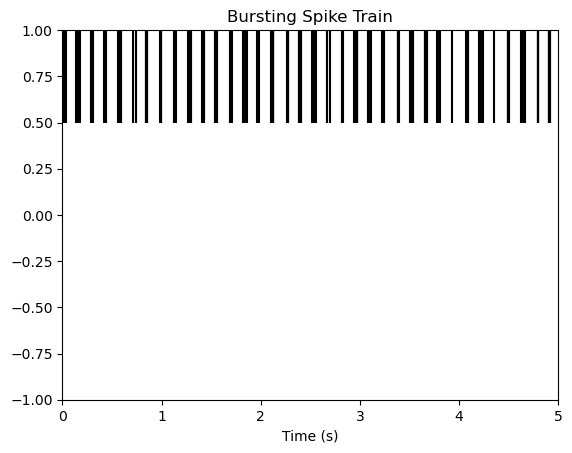

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_bursting_poisson(rate_burst, rate_interburst, burst_duration, interburst_duration, total_duration):
    spike_times = []
    time = 0
    
    while time < total_duration:
        # Burst period
        burst_spikes = np.cumsum(np.random.exponential(1/rate_burst, int(rate_burst * burst_duration)))
        burst_spikes = burst_spikes[burst_spikes < burst_duration] + time
        spike_times.extend(burst_spikes)
        time += burst_duration
        
        if time >= total_duration:
            break
        
        # Interburst period
        inter_spikes = np.cumsum(np.random.exponential(1/rate_interburst, int(rate_interburst * interburst_duration)))
        inter_spikes = inter_spikes[inter_spikes < interburst_duration] + time
        spike_times.extend(inter_spikes)
        time += interburst_duration

    # Trim spikes beyond total_duration
    spike_times = np.array(spike_times)
    spike_times = spike_times[spike_times < total_duration]
    
    return spike_times

# Parameters
N = 10
rate_burst = 150  # Hz
rate_interburst = 0.00001  # Hz
burst_duration = 0.04  # s
interburst_duration = 0.1  # s
total_duration = 5  # s

df_burst = pd.DataFrame(columns=['spiking_times', 'ID'])

for i in range(N):
    sp = generate_bursting_poisson(rate_burst, rate_interburst, burst_duration, interburst_duration, total_duration)
    sp = np.array(sp) * 1000  # Convert to ms
    df_burst = pd.concat([df_burst, pd.DataFrame({'spiking_times': [sp.tolist()], 'ID': [i]})], ignore_index=True)

df_burst.to_csv('tmp/bursting_poisson_spike_train.csv', index=False)

# Optional visualization of one trial
plt.eventplot(sp / 1000, orientation='horizontal', color='black')
plt.xlim(0, total_duration)
plt.ylim(-1, 1)
plt.xlabel('Time (s)')
plt.title('Bursting Spike Train')
plt.show()


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch.utils.data import Dataset, DataLoader
import numpy as np
from inference import SpikeFeatureExtractor
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
import os

def check_for_nans(name, tensor):
    if torch.isnan(tensor).any():
        print(f"🚨 NaNs detected in {name}")
        return True
    return False

class Embedder(nn.Module):
    def __init__(self, d_encoder, dropout, should_log, max_len=1000):
        super(Embedder, self).__init__()
        self.d_encoder = d_encoder
        self.should_log = should_log
        self.max_len = max_len
        self.linear = nn.Linear(2, d_encoder)
        self.dropout = nn.Dropout(dropout)
        self.positional_encoding = self.get_sin_cos_positional_encoding(max_len, d_encoder)
        self.register_buffer('pe', self.positional_encoding)
        self.register_buffer('mu', torch.zeros(2))
        self.register_buffer('sigma', torch.ones(2))

    def init_mu_sigma(self, mu, sigma):
        """
        :param mu: mean of the training set
        :param sigma: standard deviation of the training set
        """

        # on the right device ?
        mu = mu.to(self.mu.device)
        sigma = sigma.to(self.sigma.device)
        # check the size
        if mu.size() != (2,):
            raise ValueError(f"mu should be of size (2,), but got {mu.size()}")
        if sigma.size() != (2,):
            raise ValueError(f"sigma should be of size (2,), but got {sigma.size()}")
        
        self.mu.copy_(mu)
        self.sigma.copy_(sigma)

    def get_sin_cos_positional_encoding(self, max_len, d_model):
        """
        :param max_len: maximum length of the sequence
        :param d_model: dimension of the model
        :return: positional encoding matrix of shape (max_len, d_model)
        """
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe
    
    def forward(self, x, L):
        """
        :param x: input sequence of shape (batch_size, seq_len)
        :param L: length of the sequences before padding of shape (batch_size,)
        :return: embedded sequence of shape (batch_size, seq_len, d_encoder) and mask of shape (batch_size, seq_len - 1)
        """

        # == from x to x_features ==
        # x is the sequence of spike times
        # L is the length of the sequences before padding
        # we compute the ISIs
        if not self.should_log:
            x_ISI = torch.diff(x, dim=1)
        else:
            x_ISI = torch.log1p(torch.abs(torch.diff(x, dim=1)))
        L = L - 1
        # we compute the delta ISIs
        delta_ISI = torch.diff(x_ISI, dim=1)
        # we pad delta_ISI with one zero at the beginning
        delta_ISI = F.pad(delta_ISI, (1, 0), value=0)
        # we stack x_ISI and delta_ISI
        x_features = torch.stack((x_ISI, delta_ISI), dim=-1)
        # we normalize the features
        x_features = (x_features - self.mu) / self.sigma

        # == from x_features to z_emb ==

        # we apply the linear layer
        x_features = self.linear(x_features)
        # we add the positional encoding
        x_features = x_features + self.pe[:x_features.size(1), :]
        # we apply the dropout
        x_features = self.dropout(x_features)
        # we create the mask
        mask = torch.arange(x_features.size(1)).unsqueeze(0) < L.unsqueeze(1)
        mask = mask.to(x_features.device)
        # we apply the mask
        x_features = x_features * mask.unsqueeze(-1).float()
        # we return the embedded sequence and the mask

        # we check for NaNs
        if check_for_nans("x_features", x_features):
            raise ValueError("NaNs detected in x_features")

        return x_features, mask
    
class InteractionCore(nn.Module):
    def __init__(self, d_encoder, n_heads, dropout, n_blocks, activation):
        super(InteractionCore, self).__init__()

        if activation == 'relu':
            activation = nn.ReLU()
        elif activation == 'gelu':
            activation = nn.GELU()
        elif activation == 'silu':
            activation = nn.SiLU()
        elif activation == 'tanh':
            activation = nn.Tanh()

        self.d_encoder = d_encoder
        self.n_heads = n_heads
        self.dropout = dropout
        self.n_blocks = n_blocks
        self.activation = activation

        # Define the multi-head attention and feed-forward layers
        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(d_encoder, n_heads, dropout=dropout, batch_first=True) for _ in range(n_blocks)])
        self.feed_forward_layers = nn.ModuleList([nn.Sequential(
            nn.Linear(d_encoder, d_encoder),
            activation,
            nn.Dropout(dropout),
            nn.Linear(d_encoder, d_encoder)
        ) for _ in range(n_blocks)])
        # Define layer normalization
        self.layer_norms1 = nn.ModuleList([nn.LayerNorm(d_encoder) for _ in range(n_blocks)])
        self.layer_norms2 = nn.ModuleList([nn.LayerNorm(d_encoder) for _ in range(n_blocks)])
        # Define dropout layers
        self.dropout_layers = nn.ModuleList([nn.Dropout(dropout) for _ in range(n_blocks)])
        # Define activation function
        self.activation_fn = activation
        # Define the final linear layer
        self.final_linear = nn.Linear(d_encoder, d_encoder)
        # Define the final layer normalization
        self.final_layer_norm = nn.LayerNorm(d_encoder)
        # Define the final dropout layer
        self.final_dropout = nn.Dropout(dropout)
        # Define the final activation function
        self.final_activation = activation

    def forward(self, x, mask):
        """
        :param x: input sequence of shape (batch_size, seq_len, d_encoder)
        :param mask: attention mask of shape (batch_size, seq_len)
        :return: processed sequence of shape (batch_size, seq_len, d_encoder) and mask of shape (batch_size, seq_len)
        """

        # == from z_emb to z_core ==
        # x is the embedded sequence
        # mask is the attention mask

        for i in range(self.n_blocks):
            # Multi-head attention
            attn_output, _ = self.attention_layers[i](x, x, x, key_padding_mask=~mask)
                
            # check for NaNs
            # it comes from here. Check why by inspecting the mask
            if check_for_nans("attn_output", attn_output):
                raise ValueError("NaNs detected in attn_output")

            x = x + self.dropout_layers[i](attn_output)
            x = self.layer_norms1[i](x)

            # Feed-forward network
            ff_output = self.feed_forward_layers[i](x)
            ff_output = self.activation_fn(ff_output)

            x = x + self.dropout_layers[i](ff_output)
            x = self.layer_norms2[i](x)
            # check for NaNs
            if check_for_nans("ff_output", ff_output):
                raise ValueError("NaNs detected in ff_output")
            if check_for_nans("x", x):
                raise ValueError("NaNs detected in x attention core")

        # Final linear layer
        x = self.final_linear(x)
        # Final layer normalization
        x = self.final_layer_norm(x)
        # Final dropout layer
        x = self.final_dropout(x)
        # Final activation function
        x = self.final_activation(x)
        # Return the processed sequence and mask

        #if check_for_nans("x", x):
        #    raise ValueError("NaNs detected in x after interaction core")

        return x, mask
    
class Pooler(nn.Module):
    def __init__(self, d_encoder, d_latent, dropout, activation):
        super(Pooler, self).__init__()

        if activation == 'relu':
            activation_fn = nn.ReLU()
        elif activation == 'gelu':
            activation_fn = nn.GELU()
        elif activation == 'silu':
            activation_fn = nn.SiLU()
        elif activation == 'tanh':
            activation_fn = nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")

        self.d_encoder = d_encoder
        self.d_latent = d_latent
        self.dropout = dropout
        self.activation_fn = activation_fn

        self.W_K = nn.Linear(d_encoder, d_encoder)
        self.W_pool = nn.Linear(d_encoder, d_latent)

        self.dropout_layer = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_encoder)
        self.softmax = nn.Softmax(dim=-1)

        # Learnable query vector (shared across all batches)
        self.query_vector = nn.Parameter(torch.randn(1, 1, d_encoder))

    def forward(self, x, mask):
        """
        :param x: Tensor of shape (batch_size, seq_len, d_encoder)
        :param mask: Bool tensor of shape (batch_size, seq_len), where True means valid token
        :return: Tensor of shape (batch_size, d_latent), and original mask
        """

        batch_size, seq_len, _ = x.size()

        # Compute keys from input
        K = self.W_K(x)  # (B, T, d_encoder)

        # Expand query vector to match batch size
        Q = self.query_vector.expand(batch_size, -1, -1)  # (B, 1, d_encoder)

        # Attention scores (B, 1, T)
        attn_scores = torch.bmm(Q, K.transpose(1, 2)) / (self.d_encoder ** 0.5)
        with torch.cuda.amp.autocast(enabled=False):
            attn_scores = attn_scores.masked_fill(~mask.unsqueeze(1), float('-inf'))
            attn_weights = self.softmax(attn_scores.float()).to(attn_scores.dtype)

        # Check for NaNs
        #if check_for_nans("attn_weights", attn_weights):
        #    raise ValueError("NaNs detected in attn_weights")

        # Weighted sum of values (pooled representation)
        pooled_representation = torch.bmm(attn_weights, x)  # (B, 1, d_encoder)
        pooled_representation = pooled_representation.squeeze(1)  # (B, d_encoder)

        # Normalize, project, and activate
        pooled_representation = self.layer_norm(pooled_representation)
        pooled_representation = self.W_pool(pooled_representation)
        pooled_representation = self.dropout_layer(pooled_representation)
        pooled_representation = self.activation_fn(pooled_representation)

        # Check for NaNs
        #if check_for_nans("pooled_representation", pooled_representation):
        #    raise ValueError("NaNs detected in pooled_representation")

        return pooled_representation, mask
    
class Encoder(nn.Module):
    def __init__(self, d_encoder, n_heads, dropout, n_blocks, d_latent, activation, should_log):
        super(Encoder, self).__init__()
        self.embedder = Embedder(d_encoder, dropout, should_log)
        self.interaction_core = InteractionCore(d_encoder, n_heads, dropout, n_blocks, activation)
        self.pooler = Pooler(d_encoder, d_latent, dropout, activation)
        
    def init_mu_sigma(self, mu, sigma):
        """
        :param mu: mean of the training set
        :param sigma: standard deviation of the training set
        """
        self.embedder.init_mu_sigma(mu, sigma)

    def forward(self, x, L):
        """
        :param x: input sequence of shape (batch_size, seq_len)
        :param L: length of the sequences before padding of shape (batch_size,)
        :return: pooled sequence of shape (batch_size, d_latent)
        """
        # Embed the input sequence
        x_emb, mask = self.embedder(x, L)

        # Process the embedded sequence through the interaction core
        x_core, mask = self.interaction_core(x_emb, mask)

        # Pool the processed sequence to obtain a fixed-size representation
        x_latent, mask = self.pooler(x_core, mask)

        return x_latent
    
class Decoder(nn.Module):
    def __init__(self, d_latent, dropout, n_blocks, activation, inference_only=False):
        super(Decoder, self).__init__()

        if activation == 'relu':
            activation = nn.ReLU()
        elif activation == 'gelu':
            activation = nn.GELU()
        elif activation == 'silu':
            activation = nn.SiLU()
        elif activation == 'tanh':
            activation = nn.Tanh()

        self.d_latent = d_latent
        self.dropout = dropout
        self.n_blocks = n_blocks
        self.activation = activation

        # Define the residual feedforward networks
        self.ff_layers = nn.ModuleList([nn.Sequential(
            nn.Linear(d_latent, d_latent),
            self.activation,
            nn.Dropout(dropout),
            nn.Linear(d_latent, d_latent)
        ) for _ in range(n_blocks)])
        # Define layer normalization
        self.layer_norms1 = nn.ModuleList([nn.LayerNorm(d_latent) for _ in range(n_blocks)])
        self.layer_norms2 = nn.ModuleList([nn.LayerNorm(d_latent) for _ in range(n_blocks)])
        # Define dropout layers
        self.dropout_layers = nn.ModuleList([nn.Dropout(dropout) for _ in range(n_blocks)])
        # Define the final linear layer
        self.W_final = nn.Linear(d_latent, 2)

        # AUXILIARY
        if not inference_only:
            # Define the auxiliary head for classification
            self.classification_head = nn.ModuleList([nn.Sequential(
                nn.Linear(d_latent, d_latent),
                self.activation,
                nn.Dropout(dropout),
                nn.Linear(d_latent, d_latent)
            ) for _ in range(2)])
            # Define layer normalization for the classification head
            self.classification_layer_norms = nn.ModuleList([nn.LayerNorm(d_latent) for _ in range(2)])
            # Define dropout layers for the classification head
            self.classification_dropout_layers = nn.ModuleList([nn.Dropout(dropout) for _ in range(2)])
            # Define the final linear layer for the classification head
            self.classification_final = nn.Linear(d_latent, 2)

            # Define the auxiliary head for metrics
            self.metrics_head = nn.ModuleList([nn.Sequential(
                nn.Linear(d_latent, d_latent),
                self.activation,
                nn.Dropout(dropout),
                nn.Linear(d_latent, d_latent)
            ) for _ in range(2)])
            # Define layer normalization for the metrics head
            self.metrics_layer_norms = nn.ModuleList([nn.LayerNorm(d_latent) for _ in range(2)])
            # Define dropout layers for the metrics head
            self.metrics_dropout_layers = nn.ModuleList([nn.Dropout(dropout) for _ in range(2)])
            # Define the final linear layer for the metrics head
            self.metrics_final = nn.Linear(d_latent, 5)
            # Define the auxiliary head for uncertainty
            self.uncertainty_head = nn.ModuleList([nn.Sequential(
                nn.Linear(d_latent, d_latent),
                self.activation,
                nn.Dropout(dropout),
                nn.Linear(d_latent, d_latent)
            ) for _ in range(2)])
            # Define layer normalization for the uncertainty head
            self.uncertainty_layer_norms = nn.ModuleList([nn.LayerNorm(d_latent) for _ in range(2)])
            # Define dropout layers for the uncertainty head
            self.uncertainty_dropout_layers = nn.ModuleList([nn.Dropout(dropout) for _ in range(2)])
            # Define the final linear layer for the uncertainty head
            self.uncertainty_final = nn.Linear(d_latent, 2)

            # INITIALIZE THE UNCERTAINTY HEAD WITH VERY SMALL VALUES
            self.uncertainty_final.weight.data *= 0.01

        else:
            # In inference mode, we don't need the auxiliary heads
            self.classification_head = None
            self.metrics_head = None
            self.uncertainty_head = None

            print("Inference mode: Auxiliary heads are not used.")

        # two vectors of parameters of size d_latent
        self.blending_vector_c = nn.Parameter(torch.randn(d_latent))
        self.blending_vector_m = nn.Parameter(torch.randn(d_latent))

    def predict(self, x):
        raise NotImplementedError("Please use forward_auxilliary method for training and predict for inference")
    
    def forward(self, x):
        #raise an error, we should use either predict or forward_auxilliary
        raise NotImplementedError("Please use predict method for inference and forward_auxilliary for training")

    def forward_auxilliary(self, x):
        """
        :param x: input sequence of shape (batch_size, d_latent)
        :return: output sequence of shape (batch_size, 2) and auxiliary outputs
        """

        x_temp = x

        # == from z_latent to y_hat_aux ==
        # we compute the classification head
        if self.classification_head is not None:
            x_aux_c = x_temp
            for i in range(2):
                ff_output = self.classification_head[i](x_aux_c)
                ff_output = self.activation(ff_output)
                x_aux_c = x_aux_c + self.classification_dropout_layers[i](ff_output)
                x_aux_c = self.classification_layer_norms[i](x_aux_c)

            y_hat_aux_c = self.classification_final(x_aux_c)

            x_aux_m = x_temp
            # we compute the metrics head
            for i in range(2):
                ff_output = self.metrics_head[i](x_aux_m)
                ff_output = self.activation(ff_output)
                x_aux_m = x_aux_m + self.metrics_dropout_layers[i](ff_output)
                x_aux_m = self.metrics_layer_norms[i](x_aux_m)

            y_hat_aux_m = self.metrics_final(x_aux_m)

            # == from z_latent to y_hat ==
            # x is the fixed-size representation
            x_aux = x_temp + self.blending_vector_c * x_aux_c + self.blending_vector_m * x_aux_m
            for i in range(self.n_blocks):
                # Feed-forward network
                ff_output = self.ff_layers[i](x_aux)
                ff_output = self.activation(ff_output)
                x_aux = x_aux + self.dropout_layers[i](ff_output)
                x_aux = self.layer_norms1[i](x_aux)

            # check
            #if check_for_nans("x", x):
            #    raise ValueError("NaNs detected in x in the decoder")

            # Final linear layer
            y_hat = self.W_final(x_aux)

            # we compute the uncertainty head
            for i in range(2):
                ff_output = self.uncertainty_head[i](x_aux)
                ff_output = self.activation(ff_output)
                x_aux = x_aux + self.uncertainty_dropout_layers[i](ff_output)
                x_aux = self.uncertainty_layer_norms[i](x_aux)
            y_hat_aux_s = self.uncertainty_final(x_aux)

            # check
            #if check_for_nans("y_hat_aux_c", y_hat_aux_c):
            #    raise ValueError("NaNs detected in y_hat_aux_c in the decoder")
            #if check_for_nans("y_hat_aux_m", y_hat_aux_m):
            #    raise ValueError("NaNs detected in y_hat_aux_m in the decoder")
            #if check_for_nans("y_hat_aux_s", y_hat_aux_s):
            #    raise ValueError("NaNs detected in y_hat_aux_s in the decoder")
            # check
            #if check_for_nans("y_hat", y_hat):
            #    raise ValueError("NaNs detected in y_hat in the decoder")

            return y_hat, y_hat_aux_c, y_hat_aux_m, y_hat_aux_s

        return y_hat
        
class DICsNet(nn.Module):
    def __init__(self, d_encoder, n_heads, dropout, n_blocks_encoder, n_blocks_decoder, d_latent, activation, inference_only=False, should_log=False):
        super(DICsNet, self).__init__()
        self.encoder = Encoder(d_encoder, n_heads, dropout, n_blocks_encoder, d_latent, activation, should_log)
        self.decoder = Decoder(d_latent, dropout, n_blocks_decoder, activation, inference_only=inference_only)

    def init_mu_sigma(self, mu, sigma):
        """
        :param mu: mean of the training set
        :param sigma: standard deviation of the training set
        """
        self.encoder.embedder.init_mu_sigma(mu, sigma)

    def predict(self, x, L):
        """
        :param x: input sequence of shape (batch_size, seq_len)
        :param L: length of the sequences before padding of shape (batch_size,)
        :return: output sequence of shape (batch_size, 2)
        """
        # Forward pass through the encoder
        x_latent = self.encoder(x, L)
        # Forward pass through the decoder
        y_hat = self.decoder.predict(x_latent)
        return y_hat
    def forward(self, x):
        raise NotImplementedError("Please use predict method for inference and forward_auxilliary for training")
    def forward_auxilliary(self, x, L):
        """
        :param x: input sequence of shape (batch_size, seq_len)
        :param L: length of the sequences before padding of shape (batch_size,)
        :return: output sequence of shape (batch_size, 2) and auxiliary outputs
        """
        # Forward pass through the encoder
        x_latent = self.encoder(x, L)

        # check for NaNs
        if check_for_nans("x_latent", x_latent):
            raise ValueError("NaNs detected in x_latent")

        # Forward pass through the decoder
        y_hat, y_hat_aux_c, y_hat_aux_m, y_hat_aux_s = self.decoder.forward_auxilliary(x_latent)
        
        return y_hat, y_hat_aux_c, y_hat_aux_m, y_hat_aux_s
    
    @staticmethod
    def HeteroscedasticHuberLoss(y, y_hat, log_sigma):
        """
        :param y: ground truth values
        :param y_hat: predicted values
        :param log_sigma: log of predicted uncertainties
        :return: heteroscedastic Huber loss
        """
        delta = 1.0

        #clamp
        log_sigma = torch.clamp(log_sigma, min=-5, max=2)

        # Compute sigma from log_sigma
        sigma = torch.exp(log_sigma)

        if torch.any(torch.isnan(sigma)):
            raise ValueError("NaN values detected in sigma")

        # Compute the Huber loss
        huber_loss = torch.where(torch.abs(y - y_hat) < delta,
                                0.5 * (y - y_hat) ** 2,
                                delta * (torch.abs(y - y_hat) - 0.5 * delta))
        # Compute the heteroscedastic loss
        heteroscedastic_loss = huber_loss / (sigma ** 2 + 1e-6) + 2 * log_sigma
        return heteroscedastic_loss.mean()

class SpikeTrainDataset(Dataset):
    def __init__(self, data_path, noise_level=2.0, should_log=False, frac=1.0, cherry_pick=False, nl=0):
        
        self.data_path = data_path
        self.noise_level = noise_level
        self.should_log = should_log
        self.spike_feature_extractor = SpikeFeatureExtractor(model="stg")
        self.cherry_pick = cherry_pick
        self.nl = nl

        with np.errstate(all='ignore'):  # Suppress warnings for empty slices

            f = frac

            data_csv = pd.read_csv(data_path, usecols=["g_s", "g_u", "spiking_times"]).sample(frac=f, random_state=42)
            #num_workers_slurm = os.environ.get("SLURM_CPUS_PER_TASK")
            #num_workers_slurm = int(num_workers_slurm)

            num_workers_slurm = 16

            self.data = self.spike_feature_extractor.extract_from_dataframe(data_csv, num_workers=num_workers_slurm, verbose=True)
            # put back g_s and g_u in the data
            self.data["g_s"] = data_csv["g_s"].values
            self.data["g_u"] = data_csv["g_u"].values

            # if 'ID' in data_csv.columns:
            #     self.data["ID"] = data_csv["ID"].values
            if "ID" in data_csv.columns:
                self.data["ID"] = data_csv["ID"].values

            # data_csv not needed anymore
            del data_csv

        self.data = self.load_data()
        # we group by (g_s, g_u) and pick one sample per group
        if cherry_pick:
            self.data = self.data.groupby(["g_s", "g_u"]).apply(lambda x: x.sample(1)).reset_index(drop=True)
            print(f"Number of samples after cherry picking: {len(self.data)}")


    def load_data(self):
        # clean and process the data
        # Print the number of saples with each label
        data = self.data.dropna()
        silent = data[data["label"] == 0]
        spiking = data[data["label"] == 1]
        bursting = data[data["label"] == 2]
        print(f"Number of samples with label 0: {len(silent)}")
        print(f"Number of samples with label 1: {len(spiking)}")
        print(f"Number of samples with label 2: {len(bursting)}")
        # drop silent
        data = data[data["label"] != 0]

        # spiking_times is x
        # (g_s, g_u) is main y
        # (f_spiking, f_intra_bursting, f_inter_bursting, duration_bursting, nbr_spikes_bursting) is aux metrics y
        # label is aux classification y        

        # we need to compute mu and sigma of ISI and delta ISI
        if not self.should_log:
            data["mean_ISI"] = data["spiking_times"].apply(lambda x: np.mean(np.diff(x)))
            data["std_ISI"] = data["spiking_times"].apply(lambda x: np.std(np.diff(x)))
            data["mean_delta_ISI"] = data["spiking_times"].apply(lambda x: np.mean(np.diff(np.diff(x))))
            data["std_delta_ISI"] = data["spiking_times"].apply(lambda x: np.std(np.diff(np.diff(x))))
        else:
            data["mean_ISI"] = data["spiking_times"].apply(lambda x: np.mean(np.log1p(np.diff(x))))
            data["std_ISI"] = data["spiking_times"].apply(lambda x: np.std(np.log1p(np.diff(x))))
            data["mean_delta_ISI"] = data["spiking_times"].apply(lambda x: np.mean(np.diff(np.log1p(np.diff(x)))))
            data["std_delta_ISI"] = data["spiking_times"].apply(lambda x: np.std(np.diff(np.log1p(np.diff(x)))))


        mean_ISI = data["mean_ISI"].mean()
        std_ISI = data["std_ISI"].mean()
        mean_delta_ISI = data["mean_delta_ISI"].mean()
        std_delta_ISI = data["std_delta_ISI"].mean()

        print(f"mean_ISI: {mean_ISI}, std_ISI: {std_ISI}", flush=True)
        print(f"mean_delta_ISI: {mean_delta_ISI}, std_delta_ISI: {std_delta_ISI}", flush=True)

        # into torch tensor
        self.mu = torch.tensor([mean_ISI, mean_delta_ISI])
        self.sigma = torch.tensor([std_ISI, std_delta_ISI])

        return data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # get the sample
        sample = self.data.iloc[idx]
        # get the spike times
        spike_times = sample["spiking_times"]
        # get the label
        label = sample["label"] - 1  # 0 for spiking, 1 for bursting
        # get the g_s and g_u
        g_s = sample["g_s"]
        g_u = sample["g_u"]
        # get the metrics
        f_spiking = sample["f_spiking"]
        f_intra_bursting = sample["f_intra_bursting"]
        f_inter_bursting = sample["f_inter_bursting"]
        duration_bursting = sample["duration_bursting"]
        nbr_spikes_bursting = sample["nbr_spikes_bursting"]

        # add noise to the spike times
        if self.noise_level is not None:
            # add Gaussian noise

            spike_times = [t + np.random.normal(0, self.noise_level) for t in spike_times]
            
            # apply dropout
            l_spike_times = [t for t in spike_times if np.random.rand() > 0.05]
            if len(l_spike_times) < 5:
                l_spike_times = spike_times
            spike_times = l_spike_times
            # apply windowing only if the number of spikes is greater than 10
            num_spikes = len(spike_times)
            if num_spikes > 10:
                # sample the number of spikes for the recording window
                num_window_spikes = np.random.randint(num_spikes // 2, num_spikes)
                # sample the start index
                start_idx = np.random.randint(0, num_spikes - num_window_spikes)
                end_idx = start_idx + num_window_spikes
                # extract the window
                spike_times = spike_times[start_idx:end_idx]

        # nl is the noise level that is used to add noise to the spike times
        if self.nl > 0:
            spike_times = [t + np.random.normal(0, self.nl) for t in spike_times]
            spike_times = spike_times

        return spike_times, label, g_s, g_u, f_spiking, f_intra_bursting, f_inter_bursting, duration_bursting, nbr_spikes_bursting
    
    @staticmethod
    def collate_fn(batch):
        # collate the batch
        spike_times = [torch.tensor(sample[0], dtype=torch.float32) for sample in batch]
        labels = torch.tensor([sample[1] for sample in batch], dtype=torch.int64)
        g_s = torch.tensor([sample[2] for sample in batch], dtype=torch.float32)
        g_u = torch.tensor([sample[3] for sample in batch], dtype=torch.float32)
        f_spiking = torch.tensor([sample[4] for sample in batch], dtype=torch.float32)
        f_intra_bursting = torch.tensor([sample[5] for sample in batch], dtype=torch.float32)
        f_inter_bursting = torch.tensor([sample[6] for sample in batch], dtype=torch.float32)
        duration_bursting = torch.tensor([sample[7] for sample in batch], dtype=torch.float32)
        nbr_spikes_bursting = torch.tensor([sample[8] for sample in batch], dtype=torch.float32)

        # pad the spike times
        spike_times_padded = pad_sequence(spike_times, batch_first=True, padding_value=0)
        L = torch.tensor([len(sample) for sample in spike_times], dtype=torch.float32)

        return spike_times_padded, L, labels, g_s, g_u, f_spiking, f_intra_bursting, f_inter_bursting, duration_bursting, nbr_spikes_bursting
    
fraction_of_data = 1.0

d_encoder = 64
n_heads = 8
dropout = 0.03406899732322084
n_blocks_encoder = 4
n_blocks_decoder = 2
d_latent = 16
activation = 'gelu'
learning_rate = 2.1045121655425276e-05
should_log = True
lambda_m_factor = 9.18911907136668
lambda_c_factor = 5.443193801814643

# I increase 
num_epochs = 200
batch_size = 32*4*3*3

inference_only = False
beta2 = 0.98
weight_decay = 1e-4
val_every = 5
noise_level = 2.0
max_grad_norm = 5.0
T0 = 10

model_path = "./tmp/best_model_stg.pth"


# == TOTAL


# SETUP DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", str(device))

# SETUP MODEL
model = DICsNet(
    d_encoder=d_encoder,
    n_heads=n_heads,
    dropout=dropout,
    n_blocks_encoder=n_blocks_encoder,
    n_blocks_decoder=n_blocks_decoder,
    d_latent=d_latent,
    activation=activation,
    inference_only=inference_only,
    should_log=should_log,
    ).to(device)


# Load the model state dict
d = torch.load(model_path, map_location=device)
d = d['model_state_dict']

# load the model and print if anything is missing
missing_keys, unexpected_keys = model.load_state_dict(d, strict=False)
if len(missing_keys) > 0:
    print(f"Missing keys: {missing_keys}")
if len(unexpected_keys) > 0:
    print(f"Unexpected keys: {unexpected_keys}")
# print the model
print("Model loaded successfully")
print(str(model))
model = model.to(device)
# set the model to evaluation mode
model.eval()


from stg import simulate_individual_t_eval
from stg import get_default_u0
from stg import get_default_parameters
from utils import gamma_uniform_mean_std_matching

def get_individual(f=1/4):
    g_bar_range_Na = [0, 8000]
    g_bar_range_Kd = [0, 350]
    g_bar_range_CaT = [0, 12]
    g_bar_range_CaS = [0, 50]
    g_bar_range_KCa = [0, 250]
    g_bar_range_A = [0, 600]
    g_bar_range_H = [0, 0.7]
    g_bar_range_leak = [0, 0.02]

    g_bar_range_Na = [g_bar_range_Na[0] + (g_bar_range_Na[1] - g_bar_range_Na[0])*f, g_bar_range_Na[1] - (g_bar_range_Na[1] - g_bar_range_Na[0])*f]
    g_bar_range_Kd = [g_bar_range_Kd[0] + (g_bar_range_Kd[1] - g_bar_range_Kd[0])*f, g_bar_range_Kd[1] - (g_bar_range_Kd[1] - g_bar_range_Kd[0])*f]
    g_bar_range_CaT = [g_bar_range_CaT[0] + (g_bar_range_CaT[1] - g_bar_range_CaT[0])*f, g_bar_range_CaT[1] - (g_bar_range_CaT[1] - g_bar_range_CaT[0])*f]
    g_bar_range_CaS = [g_bar_range_CaS[0] + (g_bar_range_CaS[1] - g_bar_range_CaS[0])*f, g_bar_range_CaS[1] - (g_bar_range_CaS[1] - g_bar_range_CaS[0])*f]
    g_bar_range_KCa = [g_bar_range_KCa[0] + (g_bar_range_KCa[1] - g_bar_range_KCa[0])*f, g_bar_range_KCa[1] - (g_bar_range_KCa[1] - g_bar_range_KCa[0])*f]
    g_bar_range_A = [g_bar_range_A[0] + (g_bar_range_A[1] - g_bar_range_A[0])*f, g_bar_range_A[1] - (g_bar_range_A[1] - g_bar_range_A[0])*f]
    g_bar_range_H = [g_bar_range_H[0] + (g_bar_range_H[1] - g_bar_range_H[0])*f, g_bar_range_H[1] - (g_bar_range_H[1] - g_bar_range_H[0])*f]
    g_bar_range_leak = [g_bar_range_leak[0] + (g_bar_range_leak[1] - g_bar_range_leak[0])*f, g_bar_range_leak[1] - (g_bar_range_leak[1] - g_bar_range_leak[0])*f]
    g_bar_leak_gamma = gamma_uniform_mean_std_matching(*g_bar_range_leak)

    g_leak = np.random.gamma(g_bar_leak_gamma[0], g_bar_leak_gamma[1]) 
    g_Na = np.random.uniform(*g_bar_range_Na) * g_leak/0.01
    g_Kd = np.random.uniform(*g_bar_range_Kd) * g_leak/0.01
    g_CaT = np.random.uniform(*g_bar_range_CaT)  * g_leak/0.01
    g_CaS = np.random.uniform(*g_bar_range_CaS) * g_leak/0.01
    g_KCa = np.random.uniform(*g_bar_range_KCa) * g_leak/0.01
    g_A = np.random.uniform(*g_bar_range_A) * g_leak/0.01
    g_H = np.random.uniform(*g_bar_range_H) * g_leak/0.01
    return np.array([g_Na, g_Kd, g_CaT, g_CaS, g_KCa, g_A, g_H, g_leak])

# Example usage
individual = get_individual(f=1/4)
print(individual)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

from stg import simulate_individual_t_eval, get_default_u0, get_default_parameters
import warnings
from utils import simulate_population_t_eval_multiprocessing, get_spiking_times
from stg import generate_neuromodulated_population
from stg import DICs
from inference import SpikeFeatureExtractor
from multiprocessing import Pool
from tqdm.notebook import tqdm

V_th = -51.

spfe = SpikeFeatureExtractor(model="stg")

# Wrapper to simulate the population using multiprocessing
def simulate_population(population, U0 = get_default_u0(), T_EVAL = np.arange(3000, 4500, 0.05), PARAMS=get_default_parameters(), MAX_WORKERS=16):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        return np.asarray(simulate_population_t_eval_multiprocessing(simulate_individual_t_eval, population, U0, T_EVAL, PARAMS, MAX_WORKERS, verbose=True))[:, 1, :]
    

def get_spiking_times_wrapper(args):
    return get_spiking_times(*args)[1]
    
def get_spiking_times_population(V_population, T_EVAL, MAX_WORKERS):
        with Pool(MAX_WORKERS) as pool:
            spiking_times = list(tqdm(pool.imap(get_spiking_times_wrapper, [(T_EVAL, c) for c in V_population]), total=len(V_population)))
        return spiking_times

# example usage; simulate the individual
T_EVAL = np.arange(3000, 4500, 0.05)

device cuda
Model loaded successfully
DICsNet(
  (encoder): Encoder(
    (embedder): Embedder(
      (linear): Linear(in_features=2, out_features=64, bias=True)
      (dropout): Dropout(p=0.03406899732322084, inplace=False)
    )
    (interaction_core): InteractionCore(
      (activation): GELU(approximate='none')
      (attention_layers): ModuleList(
        (0-3): 4 x MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
      )
      (feed_forward_layers): ModuleList(
        (0-3): 4 x Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.03406899732322084, inplace=False)
          (3): Linear(in_features=64, out_features=64, bias=True)
        )
      )
      (layer_norms1): ModuleList(
        (0-3): 4 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norms2): ModuleList(
        (0-3): 4 x L

torch.Size([1, 26])
torch.Size([1])
g_s_hat: 4.7987751960754395, g_u_hat: 3.5743885040283203


/tmp/ipykernel_1824/2480116961.py:253: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
Simulating population (multiprocessing): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_1824/2235971416.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


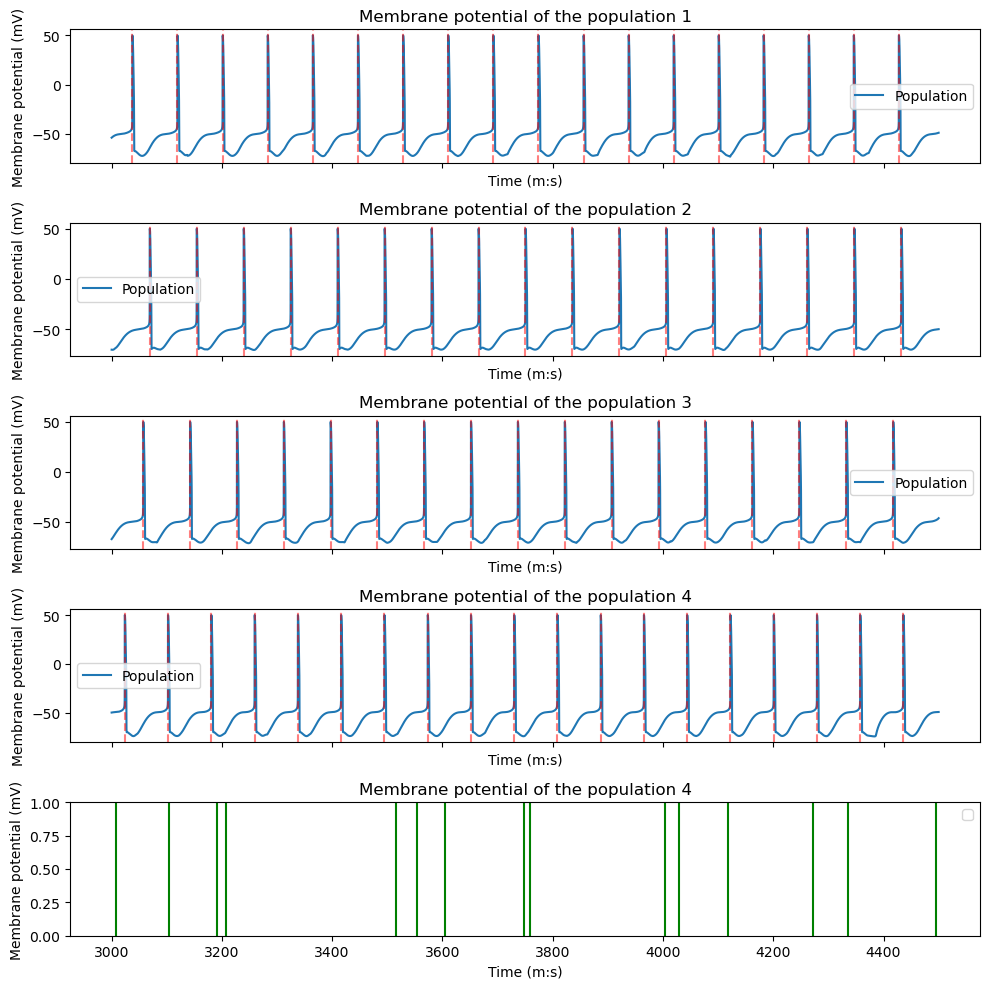

In [62]:
# we transform the spiking times to a tensor that can be used as input to the model

sp = generate_poisson_process(10, 3)
sp = np.array(sp) * 1000
spiking_times_individual = sp


spiking_times_tensor = torch.tensor(spiking_times_individual, dtype=torch.float32).unsqueeze(0).to(device)
L = torch.tensor([len(spiking_times_individual)], dtype=torch.float32)
print(spiking_times_tensor.shape)
print(L.shape)

# we get the prediction
with torch.no_grad():
    y_hat, y_hat_aux_c, y_hat_aux_m, y_hat_aux_s = model.forward_auxilliary(spiking_times_tensor, L)

g_s_hat = y_hat[0, 0].item()
g_u_hat = y_hat[0, 1].item()
print(f"g_s_hat: {g_s_hat}, g_u_hat: {g_u_hat}")

pop = generate_neuromodulated_population(4, V_th, g_s_hat, g_u_hat, iterations=5)

V_population = simulate_population(pop, U0=get_default_u0(), T_EVAL=T_EVAL, PARAMS=get_default_parameters(), MAX_WORKERS=16)
spike_times_population = get_spiking_times_population(V_population, T_EVAL, MAX_WORKERS=16)
# plot the population
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
axs = axs.flatten()
for i, (V, spikes) in enumerate(zip(V_population, spike_times_population)):
    ax = axs[i]
    ax.plot(T_EVAL, V, label="Population")
    for spike_time in spiking_times_individual:
        #ax.axvline(x=spike_time, color='g', linestyle='--', alpha=0.5)
        pass
    for spike_time in spikes:
        ax.axvline(x=spike_time, color='r', linestyle='--', alpha=0.5)
    ax.set_xlabel("Time (m:s)")
    ax.set_ylabel("Membrane potential (mV)")
    ax.set_title(f"Membrane potential of the population {i+1}")
    ax.legend()

# the last plot is the event plot spiking_times_individual

ax = axs[-1]
for spike_time in spiking_times_individual:
    if spike_time + 3000 < 4500:
        ax.axvline(x=spike_time + 3000, color='g', linestyle='-', alpha=1.0)
ax.set_xlabel("Time (m:s)")
ax.set_ylabel("Membrane potential (mV)")
ax.set_title(f"Membrane potential of the population {i+1}")
ax.legend()
# set the title of the figure
plt.tight_layout()
# save as svg
plt.savefig("figures/population_results_poisson.svg", format='svg', dpi=300)
plt.show()

torch.Size([1, 60])
torch.Size([1])
g_s_hat: -18.24129295349121, g_u_hat: 14.031682968139648


/tmp/ipykernel_1824/2480116961.py:253: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
Simulating population (multiprocessing): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_1824/2338297060.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


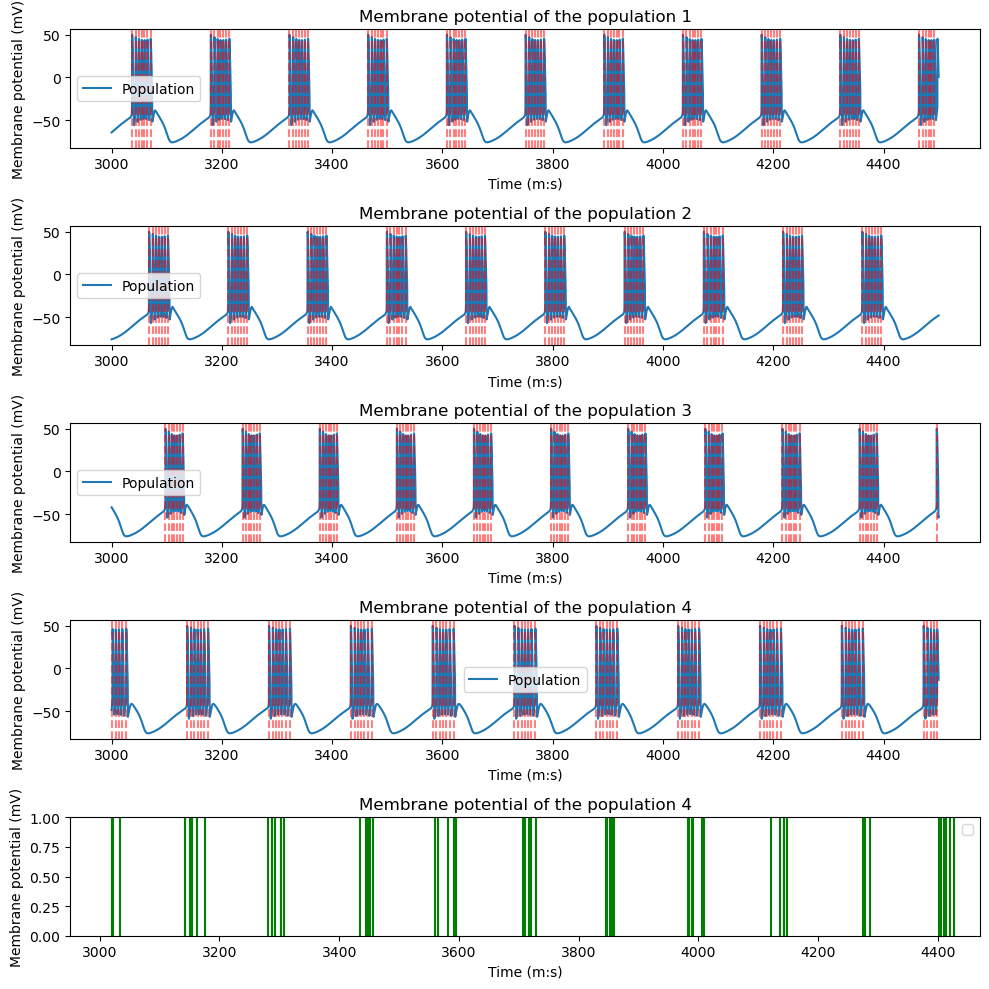

In [66]:


rate_burst = 150  # Hz
rate_interburst = 0.00001  # Hz
burst_duration = 0.04  # s
interburst_duration = 0.1  # s
total_duration = 1.5  # s

sp = generate_bursting_poisson(rate_burst, rate_interburst, burst_duration, interburst_duration, total_duration)
sp = np.array(sp) * 1000
spiking_times_individual = sp


spiking_times_tensor = torch.tensor(spiking_times_individual, dtype=torch.float32).unsqueeze(0).to(device)
L = torch.tensor([len(spiking_times_individual)], dtype=torch.float32)
print(spiking_times_tensor.shape)
print(L.shape)

# we get the prediction
with torch.no_grad():
    y_hat, y_hat_aux_c, y_hat_aux_m, y_hat_aux_s = model.forward_auxilliary(spiking_times_tensor, L)

g_s_hat = y_hat[0, 0].item()
g_u_hat = y_hat[0, 1].item()
print(f"g_s_hat: {g_s_hat}, g_u_hat: {g_u_hat}")

pop = generate_neuromodulated_population(4, V_th, g_s_hat, g_u_hat, iterations=5)

V_population = simulate_population(pop, U0=get_default_u0(), T_EVAL=T_EVAL, PARAMS=get_default_parameters(), MAX_WORKERS=16)
spike_times_population = get_spiking_times_population(V_population, T_EVAL, MAX_WORKERS=16)
# plot the population
fig, axs = plt.subplots(5, 1, figsize=(10, 10))
axs = axs.flatten()
for i, (V, spikes) in enumerate(zip(V_population, spike_times_population)):
    ax = axs[i]
    ax.plot(T_EVAL, V, label="Population")

    for spike_time in spikes:
        ax.axvline(x=spike_time, color='r', linestyle='--', alpha=0.5)
    ax.set_xlabel("Time (m:s)")
    ax.set_ylabel("Membrane potential (mV)")
    ax.set_title(f"Membrane potential of the population {i+1}")
    ax.legend()

ax = axs[-1]
for spike_time in spiking_times_individual:
    if spike_time + 3000 < 4500:
        ax.axvline(x=spike_time + 3000, color='g', linestyle='-', alpha=1.0)
ax.set_xlabel("Time (m:s)")
ax.set_ylabel("Membrane potential (mV)")
ax.set_title(f"Membrane potential of the population {i+1}")
ax.legend()
plt.tight_layout()
# save as svg
plt.savefig("figures/population_results_poisson_bursting.svg", format='svg', dpi=300)
plt.show()